In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [42]:
def load_data(filename):
    df = pd.read_csv(filename)
    df['Date'] = pd.to_datetime(df['Date'])
    return df

def calcMax(length, high):
    a = high.shape
    runningMax = np.zeros(a)
    runningMax[length-1] = max(high[:length])
    for i in range(length,a[0]):
        if high[i] >= runningMax[i-1]:
            runningMax[i] = high[i]
        elif runningMax[i-1] == high[i-length]:
            runningMax[i] = max(high[(i-length+1):(i+1)])
        else:
            runningMax[i] = runningMax[i-1]
    return runningMax

def calcMin(length, low):
    a = low.shape
    runningLow = np.zeros(a)
    runningLow[length-1] = min(low[:length])
    for i in range(length,a[0]):
        if low[i] <= runningLow[i-1]:
            runningLow[i] = low[i]
        elif runningLow[i-1] == low[i-length]:
            runningLow[i] = min(low[(i-length+1):(i+1)])
        else:
            runningLow[i] = runningLow[i-1]
    return runningLow


def calcSignal(length, rm, rl, high, low):
    a = rm.shape
    signal = np.zeros(a)
    for i in range(length,a[0]):
        if high[i] >= rm[i-1]:
            if low[i] < rl[i-1]:
                signal[i] = 0
            else:
                signal[i] = 1
        elif low[i] <= rl[i-1]:
            signal[i] = -1
    return signal


def calcDrawdown(portfolio):
    a = portfolio.shape
    drawdown = np.zeros(a)
    prevPeak = portfolio[0]
    for i in range(1,a[0]):
        if portfolio[i] < prevPeak:
            drawdown[i] = portfolio[i] - prevPeak
        elif portfolio[i] > prevPeak:
            prevPeak = portfolio[i]
    return drawdown


def calcTrades(length, stopPct, signal, close, Open, high, low, rm, rl):
    a = Open.shape
    trade = np.zeros(a)
    price = np.zeros(a)
    currentPos = 0.0
    prevPeak = 0.0
    prevTrough = 0.0
    for i in range(length,a[0]-1):
        if currentPos == 0:
            if signal[i] == 1: 
                trade[i] = 1
                currentPos = 1
                price[i] = max(rm[i-1], Open[i]);
                prevPeak = price[i]
            elif signal[i] == -1:
                trade[i] = -1
                currentPos = -1
                price[i] = min(rl[i-1],Open[i]);
                prevTrough = price[i]
        elif currentPos == 1:
            if high[i-1] > prevPeak:
                prevPeak = high[i-1]
            if low[i] <= (1-stopPct) * prevPeak:
                trade[i] = -1
                price[i] = min(Open[i], (1-stopPct)*prevPeak)
                currentPos = 0
        elif currentPos == -1:
            if low[i-1] < prevTrough:
                prevTrough = low[i-1]
            if high[i] >= (1 + stopPct) * prevTrough:
                trade[i] = 1
                price[i] = max(Open[i], (1+stopPct)*prevTrough)
                currentPos = 0
                
    if currentPos == 1:
        trade[a[0]-1] = -1
        price[a[0]-1] = close[a[0]-1]
    elif currentPos == -1:
        trade[a[0]-1] = 1
        price[a[0]-1] = close[a[0]-1]
    
#    print(sum(abs(trade)) / 2)
    return trade, price



def calcPortfolio(length, stopPct, Open, high, low, close, capital,contractSize,slippage):
    runningMax = calcMax(length, high)
    runningMin = calcMin(length, low)
    signal = calcSignal(length, runningMax, runningMin, high, low)
    trades,prices = calcTrades(length, stopPct, signal, close, Open, high, low, runningMax, runningMin)
    a = Open.shape
    port = np.zeros(a)
    port[:length] = capital
    cash = capital
    currentPos = 0
    priceTraded = 0
    slippageThisTrade = 0
    
    for i in range(length, a[0]):
        port[i] = port[i-1] + currentPos*contractSize*(Open[i] - close[i-1])
        if trades[i] == 1:
            currentPos += 1
            slippageThisTrade = (1-abs(currentPos))*slippage
            priceTraded = prices[i]
            port[i] = port[i] + currentPos*contractSize*(close[i] - priceTraded) - (1-abs(currentPos))*contractSize*(priceTraded - Open[i])        
        elif trades[i] == -1:
            currentPos -= 1
            slippageThisTrade = (1-abs(currentPos))*slippage
            priceTraded = prices[i]
            port[i] = port[i] + currentPos*contractSize*(close[i] - priceTraded) + (1-abs(currentPos))*contractSize*(priceTraded - Open[i])        
        elif trades[i] == 0:
            slippageThisTrade = 0
            port[i] = port[i] + currentPos*contractSize*(close[i]-Open[i])
    return port

    
def backtest(df, pcts, lengths, cz, slippage, capital):
    stopPct = 0
    channelLength = 0
    maxReturn = -10000000
    for i in pcts:
        for j in lengths:
            port = calcPortfolio(int(j),i,np.array(df.Open),np.array(df.High),np.array(df.Low),np.array(df.Close), capital,cz,slippage)
            ratio = (port[-1] - port[0]) / max(abs(calcDrawdown(port)))
            if ratio > maxReturn:
                stopPct = i
                channelLength = j
                maxReturn = ratio
    return stopPct, channelLength

def predict(df, pct, channelLength, cz, slippage, capital):
    portfolioVector = calcPortfolio(channelLength, pct,np.array(df.Open),np.array(df.High),np.array(df.Low),np.array(df.Close), capital,cz,slippage)
    return portfolioVector

def strategy(df, cz, slippage, capital, pcts, lengths, insamp, outsamp):
    insamp = np.timedelta64(insamp, 'Y')
    outsamp = np.timedelta64(outsamp, 'M')
    day = pd.Timedelta('1day')
    val1 = df['Date'][0]
    val2 = (df['Date'][0] + insamp + day).normalize()
    val3 = (val2 + outsamp + day).normalize()
    portfolio = np.array([])
    while val2 <= df.Date[len(df.Date)-1]:
        back = df[(df['Date'] >= val1) & (df['Date'] < val2)]
        stopPct, channelLength = backtest(back, pcts, lengths, cz, slippage, capital)
        back = df[(df['Date'] >= val2) & (df['Date'] < val3)]
        portfolio = np.append(portfolio,predict(back, stopPct, channelLength, cz, slippage, capital))
        capital = portfolio[-1]
        val1 = (val1 + outsamp + day).normalize()
        val2 = val3
        val3 = (val3 + outsamp + day).normalize()
        print(val2 < df.Date[len(df.Date)-1])
        
    print('Done')
    return portfolio

def optimize(df, cz, slippage, capital, pcts, lengths, insamp, outsamp):
    maxReturn = 0
    portfolio = 0
    t = 0
    tau = 0
    for i in insamp:
        for j in outsamp:
            port = strategy(df, cz, slippage, captial, pcts, lengths, i, j)
            ratio = (portfolio[-1] - portfolio[0]) / max(abs(calcDrawdown(port)))
            if ratio > maxReturn:
                portfolio = port
                t = i
                tau = j
                maxReturn = ratop
    return portfolio, t,tau

def runFile(opt, filename, cz, slippage, capital, pcts, lengths, insamp, outsamp):
    df = load_data(filename)
    if opt.lower() == 'strategy':
        portfolio = strategy(df, cz, slippage, capital, pcts, lengths, insamp, outsamp)
        return portfolio
    elif opt.lower() == 'optimize':
        portfolio, insample, outsample = optimize(df, cz, slippage, capital, pcts, lengths, insamp, outsamp)
        return portfolio, insample, outsample
    else:
        print('Enter Either strategy or optimize')
        

In [3]:
filename = input("Enter Filename: ")
df = load_data(filename)


Enter Filename: TY-5min.asc


In [41]:
contractSize = 2000
slippage = 19
capital = 100000
#List of Stop Percents
pcts = [0.01,0.02]
#List of Channel Lengths
channelLength = [1000,1500]
# Enter in-sample in years
insample = 5
#Enter out-sample in months
outsample = 7
portfolio = strategy(df, contractSize, slippage, capital, pcts, channelLength, insample, outsample)

(10800,)
1500
True
(11240,)
1500
True
(12000,)
1000
True
(11760,)
1000
True
(11920,)
1000
True
(11760,)
1000
True
(11840,)
1000
True
(11920,)
1000
True
(11760,)
1000
True
(12080,)
1000
True
(11680,)
1000
True
(11840,)
1500
True
(11840,)
1500
True
(11600,)
1500
True
(11920,)
1500
True
(11600,)
1500
True
(11840,)
1500
True
(11600,)
1500
True
(11600,)
1500
True
(11920,)
1000
True
(11600,)
1000
True
(11920,)
1500
True
(11680,)
1000
True
(11324,)
1500
True
(11840,)
1500
True
(11600,)
1500
True
(11792,)
1500
True
(11420,)
1500
True
(11572,)
1500
True
(11652,)
1500
True
(11554,)
1500
True
(11792,)
1000
True
(11598,)
1000
True
(11676,)
1000
True
(11720,)
1000
True
(12046,)
1500
True
(11984,)
1500
True
(12001,)
1500
True
(12088,)
1500
True
(11942,)
1500
True
(11987,)
1500
True
(12019,)
1500
True
(12022,)
1000
True
(12008,)
1500
True
(11966,)
1000
True
(12043,)
1000
True
(11918,)
1000
True
(11942,)
1000
True
(12008,)
1000
True
(11187,)
1000
False
Done


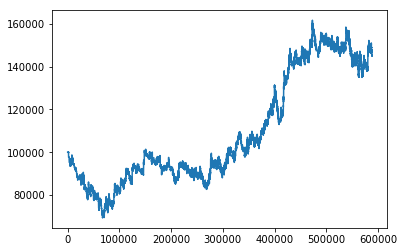

In [43]:
plt.plot(portfolio)